In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Начало работы с датасетом

In [4]:
df = pd.read_csv('Microsoft_Stock.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012


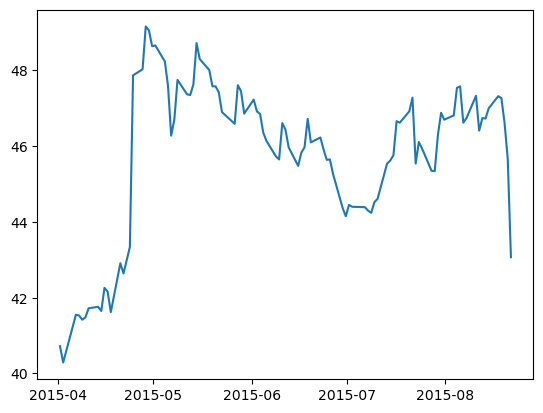

In [12]:
col = 'Close'
plt.plot('Date', col, data=df.head(100))

# Простейшая линейная модель

In [29]:
ts = df[['Close']]
# ts.loc[:, 'Date'] = ts['Date'].dt.date
ts_dates = df['Date'].dt.date
ts.reset_index(inplace=True)
ts = ts.rename(columns={'index': 't', 'Close': 'y'})
ts.head(10)

,t,y
0,0,40.72
1,1,40.29
2,2,41.55
3,3,41.53
4,4,41.42
5,5,41.48
6,6,41.72
7,7,41.76
8,8,41.65
9,9,42.26


In [31]:
n = ts.shape[0]
part = 0.8
train, test = ts.iloc[:int(n * part)], ts.iloc[int(n * part):]